In [1]:
import astropy.units as u
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
from BDFit import StarFit
from astropy.table import Table
import fnmatch

## Introduction
Here we are initializing the primary StarFit class. By default all models are included, and an internal filter list of JWST, HST, Euclid and VISTA filters have been pre-computed.

Any SVO compatible filter can be added easily, by adding the facility and instrument name to the 'facilities_to_search' argument, and adding the filter name to the 'compile_bands' list.

If you want to add filters, or recompute with a different wavelength grid, you can set the following arguments:
- 'resample_step' - the wavelength spacing in Angstrom in the wavelength grid
- 'constant_R' - if False, the resolution of the models will be kept constant with wavelength. If True, the wavelength grid will be resampled to a constant resolution of 'R'.
- 'R' - the resolution to resample to if 'constant_R' is True.
- 'min_wav' - the minimum wavelength to consider in the wavelength grid - default is 0.3 microns.
- 'max_wav' - the maximum wavelength to consider in the wavelength grid - default is 8 microns.

If you do recompile, the code will download and unpack all neccessary files from Zenodo/DataVerse, and compile the models. This can take a while, so be patient. The base models are very high resolution, and will total a few hundred GB. You can remove the downloaded files after compilation if you wish.

In [2]:
s = StarFit(verbose=True)

Library path: /nvme/scratch/work/tharvey/brown_dwarfs/models
Total models: 49212


The fitting is designed to be flexible to your catalogue. I'm just setting up some functions here to read in my catalogue, and list the filters.

In [3]:
def find_bands(table, flux_wildcard='FLUX_APER_*_aper_corr'):#, error_wildcard='FLUXERR_APER_*_loc_depth'):
    # glob-like matching for column names
    flux_columns = fnmatch.filter(table.colnames, flux_wildcard)
    # get the band names from the column names
    flux_split = flux_wildcard.split('*')
    flux_bands = [col.replace(flux_split[0], '').replace(flux_split[1], '') for col in flux_columns]
    return flux_bands

def provide_phot(table, bands=None, flux_wildcard='FLUX_APER_*_aper_corr_Jy', error_wildcard='FLUXERR_APER_*_loc_depth_10pc_Jy', min_percentage_error=0.1, flux_unit=u.Jy, multi_item_columns_slice=None):
    
    if bands is None:
        bands = find_bands(table)

    flux_columns = [flux_wildcard.replace('*', band) for band in bands]
    error_columns = [error_wildcard.replace('*', band) for band in bands]

    assert all([col in table.colnames for col in flux_columns]), f'Flux columns {flux_columns} not found in table'
    assert all([col in table.colnames for col in error_columns]), f'Error columns {error_columns} not found in table'

    if multi_item_columns_slice is not None:
        raise NotImplementedError('Do this I guess.')

    fluxes = structured_to_unstructured(table[flux_columns].as_array()) * flux_unit
    errors = structured_to_unstructured(table[error_columns].as_array()) * flux_unit

    mask = ((errors / fluxes) < min_percentage_error) & (fluxes > 0)
    errors[mask] = fluxes[mask] * min_percentage_error

    return fluxes, errors

Here we run the actual fit - fit_catalog takes a provide_phot function, which should return a flux, flux_err tuple, where the flux/flux_err arrays
have shape (ngalaxies, nfilters). The fit_catalog function will return a dictionary of the best fit parameters, and the chi-squared values.

The flux/err arrays should be astropy.Quantity objects, which will handle any flux unit conversions. 

The band names should match our band names. These can be printed as 's.model_filters'

#### Important Note! It is fine if the template library has more filters than your data - the fit will only use the filters that are present in both the data and the library.

In [4]:
catalog = '/raid/scratch/work/jarcidia/GALFIND_WORK/Catalogues/v11/ACS_WFC+NIRCam/COSMOS-Web-0A/(0.32)as/COSMOS-Web-0A_MASTER_Sel-F444W_v11.fits'
table = Table.read(catalog)
bands = find_bands(table, flux_wildcard='FLUX_APER_*_aper_corr_Jy')

s.fit_catalog(provide_phot, photometry_function_kwargs={'table': table}, bands=bands);

Warning! F410M found in multiple instruments. Keeping first, which is NIRCam. Provide instrument.band in dictionary to override this.
Warning! Assuming F814W is the same as ACS_WFC.F814W
Fitting 5 bands: ['ACS_WFC.F814W', 'F115W', 'F150W', 'F277W', 'F444W']


Here we plot the best fit and residuals for the galaxy at position 45693 in the catalogue. The plotting is flexible, and you can change the plot parameters as you wish.

/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/nvme/scratch/work/tharvey/brown_dwarfs/src/BDFit/StarFit.py:1153: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[0].add_patch(FancyArrowPatch((wavs[i], error_3sigma), (wavs[i], error_3sigma+length), color='crimson', zorder=10, edgecolor='k', arrowstyle='-|>, scaleA=3', mutation_scale=2))
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(s

27.91531298905923


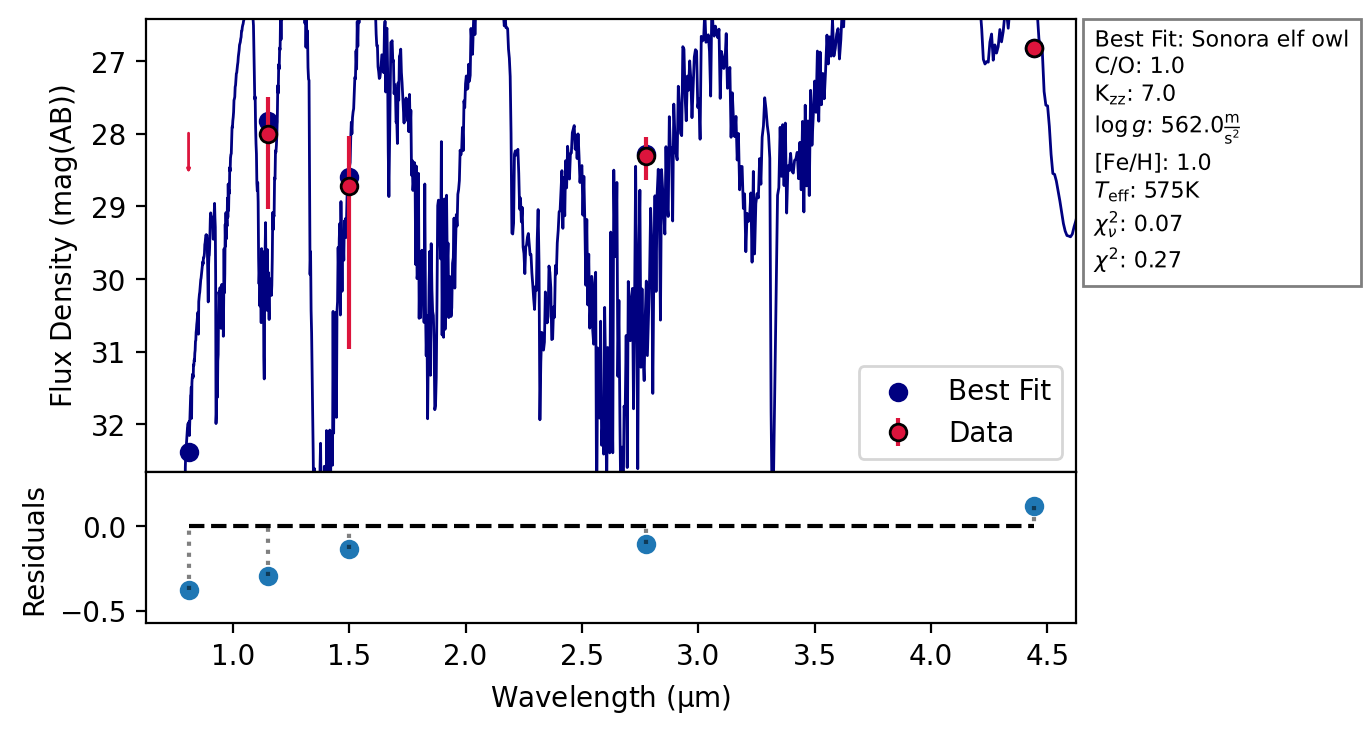

In [5]:
fig, ax = s.plot_fit(45693, flux_unit=u.ABmag);

In [6]:
print(s.model_parameters['sonora_diamondback'].keys())

dict_keys(['temp', 'log_g', 'met', 'co', 'f'])


Here is an example of generating a color-color plot from the template library, to look at the distribution of the models in a color-color space.
Any scaling of one or more filters (e.g (F356W - F410M)/F200W) can be interpreted via the x and y arguments.

In [7]:
s.color_color(x='F410M - F444W', y = 'F150W - F200W')

AttributeError: 'StarFit' object has no attribute 'color_color_plot'

We also support distance calculations for some of the models, based on the template normalization. This is a work in progress, and we are working on adding more models to this feature.